In [3]:
import h5py
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft

import iopublic

%matplotlib inline

In [4]:
f = h5py.File('/home/llandsmeer/Data/database.h5', 'r')

# Vsoma RDF

In [4]:
#tuning = '2021-12-08-shadow_averages_0.001_0.5_3447248c-68a1-4860-b512-39fa22a5fa86'
dd = []
r = np.linspace(0, 1000, 200)
dr = r[1] - r[0]
for tuning in f.keys():
    simdata = f[tuning]['none']
    network = iopublic.get_network_for_tuning(tuning)
    C = np.array([n.cluster for n in network.neurons])
    pos = np.array([(n.x, n.y, n.z) for n in network.neurons])
    rdf = np.zeros(100)
    CC = C.argsort()
    if 'sync' not in simdata:
        print(tuning, 'NA')
        continue
    sync = np.array(simdata['sync']) # gid, gjd, tfrom, tto, z
    rdf = np.zeros_like(r)
    rdf0 = np.zeros_like(r)
    rs = np.linalg.norm(pos[sync[:,0].astype(int)] - pos[sync[:,1].astype(int)], axis=1)
    rs0 = np.linalg.norm(pos[:,np.newaxis,:] - pos[np.newaxis, :, :], axis=2).flatten()
    for dist, length in zip(rs, sync[:,3] - sync[:,2]):
        idx = int(dist / dr)
        if idx >= len(rdf):
            continue
        rdf[idx] += length
    for dist in rs0:
        idx = int(dist / dr)
        if idx >= len(rdf):
            continue
        rdf0[idx] += 20000
    rdf0[0] = 1
    rdf = rdf / rdf0
    rdf[0] = 0
    dd.append((tuning, sync, pos, C, CC, rdf))
    print(tuning)

2021-12-08-shadow_averages_0.0001_0.0_965ef6ef-67f4-4903-a90d-efd8e361dc7d
2021-12-08-shadow_averages_0.0001_0.1_7c60a825-0f18-48eb-85b5-15891617c0ac
2021-12-08-shadow_averages_0.0001_0.2_5e889db2-932e-4e73-ba07-0772e4fa6a4a NA
2021-12-08-shadow_averages_0.0001_0.3_4a2657f8-e7e9-4c15-ae11-a2edcac108fc
2021-12-08-shadow_averages_0.0001_0.4_2dc970f8-41c0-4a0d-9a73-083f986023bf
2021-12-08-shadow_averages_0.0001_0.5_3447248c-68a1-4860-b512-39fa22a5fa86
2021-12-08-shadow_averages_0.0001_0.6_b07556b1-21fa-47e6-9021-20072df022c6
2021-12-08-shadow_averages_0.0001_0.7_ff526814-9232-4074-8473-16a99676c3ab
2021-12-08-shadow_averages_0.0001_0.8_d1666304-c6fc-4346-a55d-a99b3aad55be
2021-12-08-shadow_averages_0.0001_0.9_ada2023a-4377-409b-a5ce-02b6768ffe41
2021-12-08-shadow_averages_0.0001_1.0_751ac228-3e2f-4d28-9894-6972386c6977
2021-12-08-shadow_averages_0.001_0.0_965ef6ef-67f4-4903-a90d-efd8e361dc7d
2021-12-08-shadow_averages_0.001_0.1_7c60a825-0f18-48eb-85b5-15891617c0ac
2021-12-08-shadow_averag

In [ ]:
plt.figure(figsize=(10, 7))

import re
cmap = plt.get_cmap('tab20')

for tuning, sync, pos, C, CC, rdf in dd:
    if '_0.01_' not in tuning:
        continue
    m = re.search(r'_([^_]+)_([01]\.[0-9])_', tuning)
    ggap = m.group(1)
    coef = float(m.group(2))
    plt.plot(r, rdf, '.', label=f'ggap={ggap} cluster={coef}', color=cmap(coef))
    plt.plot(r, rdf, alpha=0.5, color=cmap(coef))

plt.legend()
plt.title('Radial density function of phase locking')
plt.xlabel('Soma to soma distance (um)')
plt.ylabel('Fraction of phase-locked neurons')
#plt.xlim([0, 200])

KeyboardInterrupt: 

# Vext connection

(0.0, 20.0)

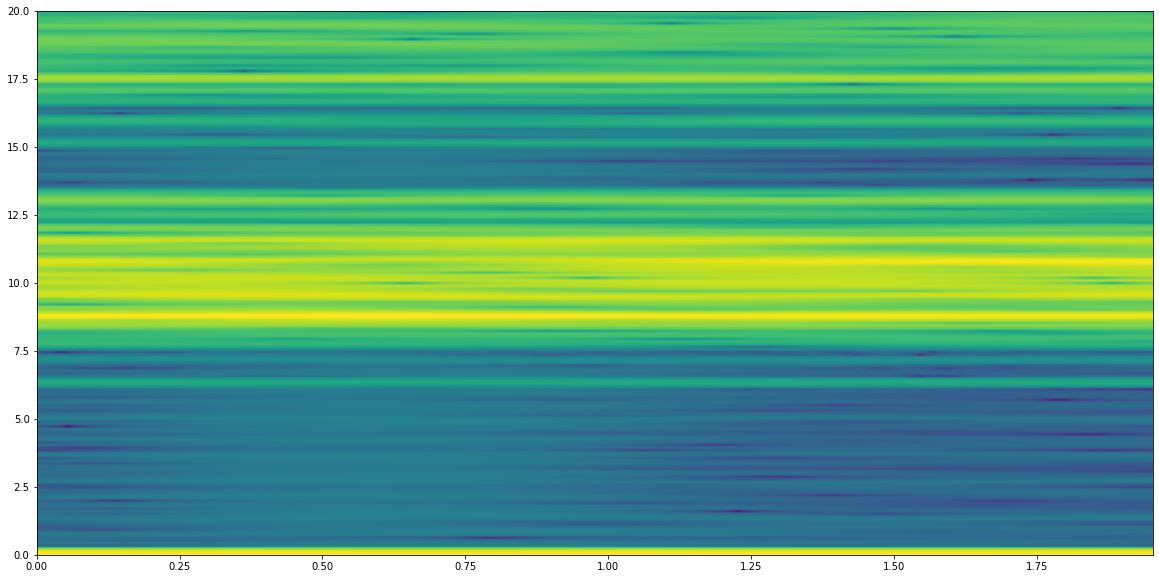

In [67]:
plt.figure(figsize=(20, 10))

window = np.blackman(128*16 + 1)

x = simdata['Vext'][1,0]

ff = np.fft.rfftfreq(len(window), 5/1000)
xw = np.lib.stride_tricks.sliding_window_view(x, window.shape) * window
xs = np.log10(np.abs(np.fft.rfft(xw)))

plt.imshow(xs.T, aspect='auto', extent=(0, len(xs)/1000, ff.max(), ff.min()))
plt.ylim([0, 20])

(0.0, 16.0)

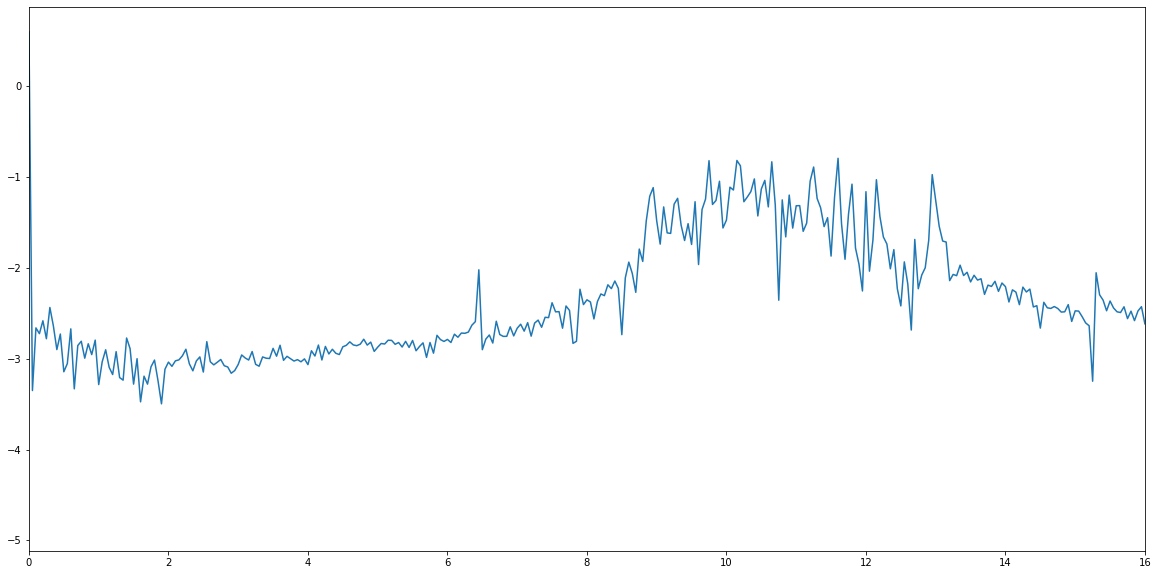

In [3]:
tuning = '2021-12-08-shadow_averages_0.001_0.5_3447248c-68a1-4860-b512-39fa22a5fa86'
x = f[tuning]['none']['Vext'][31,16]
plt.figure(figsize=(20, 10))
ff = np.fft.rfftfreq(len(x), 5/1000)
xs = np.log10(np.abs(np.fft.rfft(x)))
plt.plot(ff, xs)
plt.xlim([0, 16])

In [4]:
import emd

tuning = '2021-12-08-shadow_averages_0.001_0.5_3447248c-68a1-4860-b512-39fa22a5fa86'
x = f[tuning]['none']['Vext'][31,16]
#x = np.array(simdata['Vext'][31, 31])

In [ ]:
plt.figure(figsize=(20, 7))

sample_rate = 1/5e-3
imf = emd.sift.sift(x)
IP, IF, IA = emd.spectra.frequency_transform(imf, sample_rate, 'hilbert')
freq_range = (0.1, 10, 80, 'log')
f, hht = emd.spectra.hilberthuang(IF, IA, freq_range, sum_time=False)
emd.plotting.plot_imfs(imf, scale_y=True, cmap=True, fig=plt.gcf())
#plt.plot(imf[:,0])
#plt.plot(imf[:,2])

In [ ]:
from pyts.decomposition import SingularSpectrumAnalysis

window_size = 15
groups = [np.arange(i, i + 5) for i in range(0, 11, 5)]

X = np.array([x])

# Singular Spectrum Analysis
ssa = SingularSpectrumAnalysis()#window_size=15, groups=groups)
X_ssa = ssa.fit_transform(X)

# Show the results for the first time series and its subseries
plt.figure(figsize=(16, 6))

ax1 = plt.subplot(121)
ax1.plot(X[0], 'o-', label='Original')
ax1.legend(loc='best', fontsize=14)

ax2 = plt.subplot(122)
for i in range(len(groups)):
    ax2.plot(X_ssa[0, i], 'o--', label='SSA {0}'.format(i + 1))
ax2.legend(loc='best', fontsize=14)

plt.suptitle('Singular Spectrum Analysis', fontsize=20)

plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()

In [26]:
f = h5py.File('/home/llandsmeer/Data/database.h5', 'r')
d = {}
for tuning in f.keys():
    simdata = f[tuning]['none']
    if 'Vext' not in simdata:
        continue
    Vext = simdata['Vext']
    d[tuning] = np.array(Vext)

(-199.95000000000002, 4198.95, -0.008294493165385167, 0.10762898387743258)

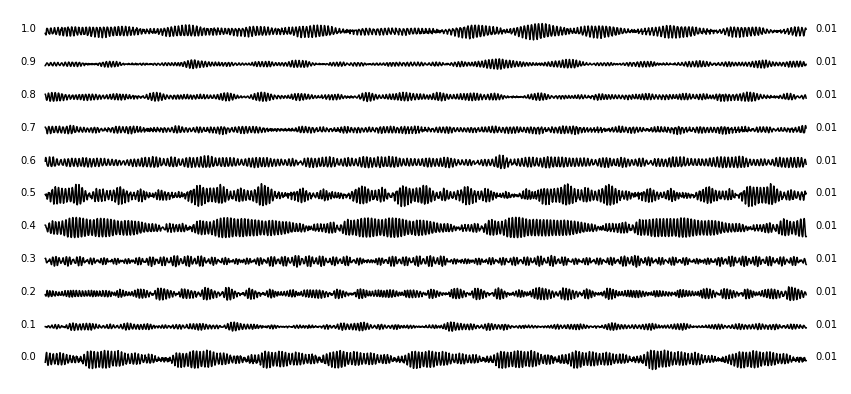

In [107]:
plt.figure(figsize=(15, 7))

import re
cmap = plt.get_cmap('hsv')

PAT = r'_([01][^_]*)_([01]\.[0-9])_'

j = 0
for i, (tuning, Vext) in enumerate(sorted(d.items(), key=lambda kv: float(re.search(PAT, kv[0]).group(2)))):
    if '_0.01_' not in tuning:  continue
    #print(tuning)
    m = re.search(PAT, tuning)
    ggap = m.group(1)
    coef = float(m.group(2))
    y0 = j/100
    x = Vext[15,30]
    #x = Vext.mean(0).mean(0)
    plt.plot(x-x.mean() + y0, color='black')#cmap(coef))
    plt.annotate(f'{coef}', (-130, y0))
    j = j + 1
    plt.annotate(f'{ggap}', (Vext.shape[2]+50, y0))
plt.axis('off')

(-199.95000000000002, 4198.95, -0.0037439231053411205, 0.053825774146942035)

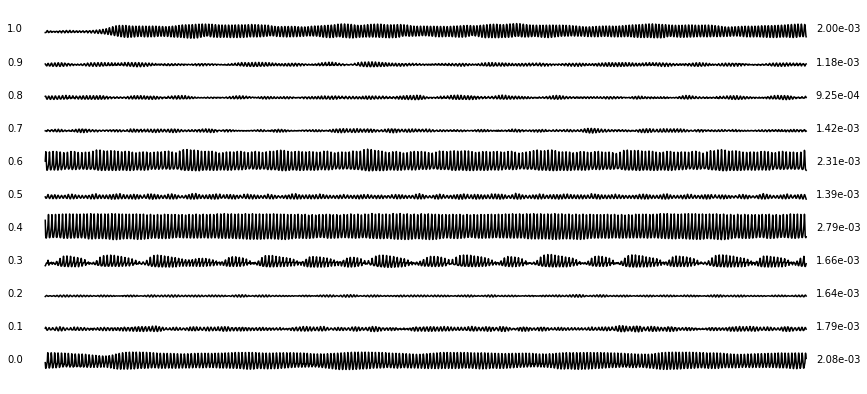

In [74]:
plt.figure(figsize=(15, 7))

import re
cmap = plt.get_cmap('tab20')

j = 0
for i, (tuning, Vext) in enumerate(d.items()):
    if '_0.01_' not in tuning:
        continue
    m = re.search(r'_([^_]+)_([01]\.[0-9])_', tuning)
    ggap = m.group(1)
    coef = float(m.group(2))
    y0 = j/200
    x = Vext[31,30]
    x = Vext[31].std(0)
    plt.plot(x-x.mean() + y0, color='black')
    plt.annotate(f'{coef}', (-200, y0))
    j = j + 1
    plt.annotate(f'{x.mean():.2e}', (Vext.shape[2]+50, y0))
plt.axis('off')

# Random

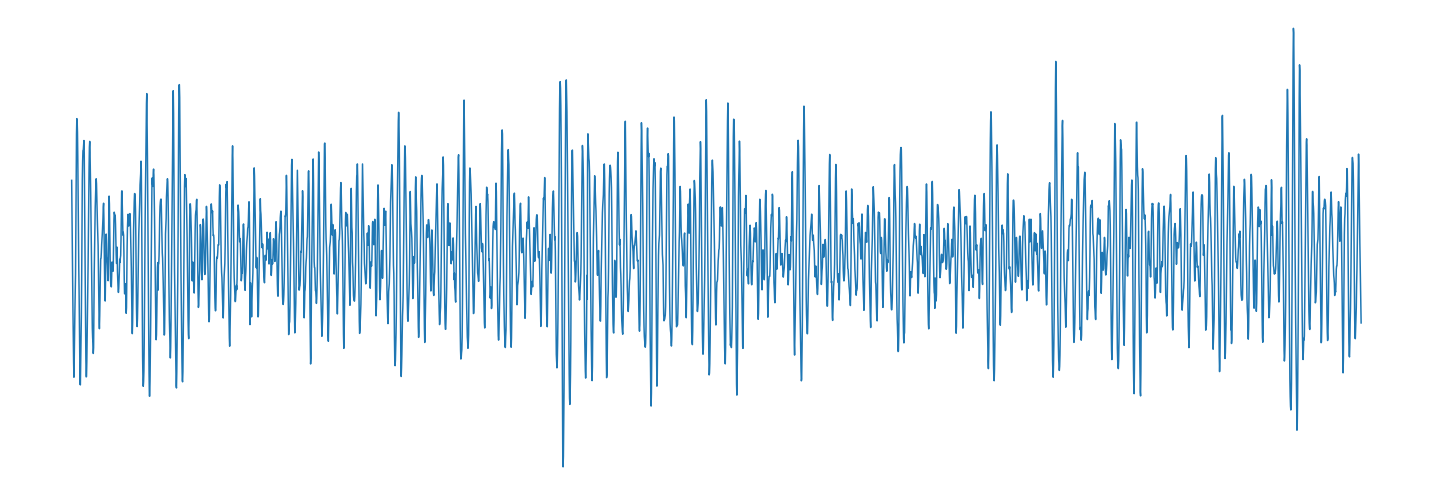

In [329]:
plt.figure(figsize=(20, 7))
plt.plot(simdata['Vext'][31,31])
plt.axis('off')
plt.tight_layout()

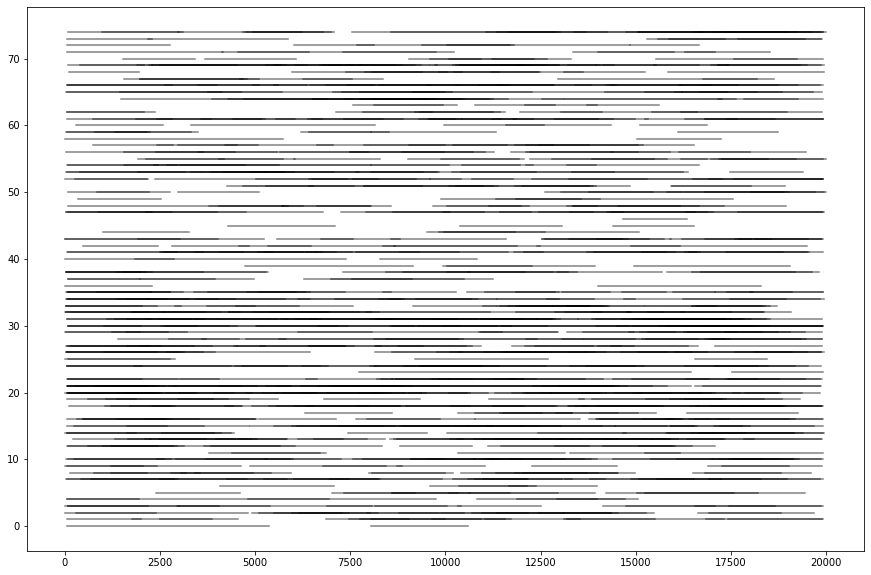

In [169]:
plt.figure(figsize=(15, 10))
#plt.hist((sync[:,3] - sync[:,2])/1e3, bins=1000);
#plt.xlim([0, 10])

for idx, (i, j, s, t, z) in enumerate(np.random.permutation(sync)):
    i, j = int(i), int(j)
    ci = CC[i]
    cj = CC[j]
    plt.plot([s, t], [C[i], C[i]], color='black', alpha=0.5)
    if idx > 1000:
        break

0.022894058311846543

In [115]:
def get_analytical(vsall):
    fs = 1000
    vs = np.copy(vsall)
    m = (vs[:,-1000:].ptp(1)<1) | np.isnan(vs).any(1)
    vs = vs[~m]
    vs = (vs - vs.mean(1)[:,None]) / vs.std(1)[:,None]
    vs[vs > 2] = 2
    vs[vs < -2] = -2
    sos = scipy.signal.butter(5, (2, 20), 'bp', fs=fs, output='sos')
    filt = scipy.signal.sosfiltfilt(sos, vs)
    analytic = scipy.signal.hilbert(filt - filt.mean())
    return np.angle(analytic)

def get_entropy(vsall):
    tmp_phase = get_analytical(vsall)
    tmp_entropies = []
    tmp_entropies2 = []
    ps = []
    ps2 = []
    for i in range(0, tmp_phase.shape[1]):
        delta = (tmp_phase[:,i] + np.pi) % (2*np.pi) - np.pi
        p, edges = np.histogram(delta, range=(-np.pi, np.pi), bins=30, density=True)
        p2 = ifft(np.abs(fft(p))**2).real / p.sum()
        x  = (edges[:-1]+edges[1:])/2
        S = -np.trapz(p * np.ma.log(p).filled(0), x)
        S2 = -np.trapz(p2 * np.ma.log(p2).filled(0), x)
        tmp_entropies.append(S)
        tmp_entropies2.append(S2)
        ps.append(p)
        ps2.append(p2)
    return np.array(tmp_entropies), np.array(tmp_entropies2), np.array(ps), np.array(ps2)

def kl(ps, idx=10000):
    q = ps[idx]
    out = []
    x = np.linspace(-np.pi, np.pi, 32)[1:-1]
    for i in range(len(ps)):
        p = ps[i]
        S = -np.trapz(p * (np.ma.log(p / q).filled(0)), x)
        out.append(S)
    return np.array(out)

#S1, S2, p1, p2 = get_entropy(simdata['vsall'])
#kl(p1)